# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                       transforms.ColorJitter(),
                                         transforms.RandomHorizontalFlip(),
                                     transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])  # Imagenet standards
                                      ])

valid_transform = transforms.Compose([transforms.Resize(size=256),
                                      transforms.CenterCrop(size=224),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
                                     
batch_size=128

# Create training set and define training dataloader

train_set = torchvision.datasets.CIFAR10(root='data/train', train=True, transform = train_transform , download = True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle=True)

# Create validation set and define validation dataloader

valid_set = torchvision.datasets.CIFAR10(root='data/valid', train=False, transform = valid_transform , download = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size , shuffle=True)

# Create test set and define test dataloader

test_set = torchvision.datasets.CIFAR10(root='data/test', train=False, transform = valid_transform , download = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_set) # length of the training set

50000

In [4]:
len(valid_set) # length of the validation set

10000

In [5]:
len(test_set) # length of the test set

10000

In [6]:
next(iter(train_loader))[0].shape  # shape of the training loader batch

torch.Size([128, 3, 224, 224])

In [7]:
next(iter(train_loader))[1].shape # training loader batch size

torch.Size([128])

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        
        std = (0.485, 0.456, 0.406)
        mean = (0.229, 0.224, 0.225)
        for i in range(3):
            image = std[i] * image + mean[i]
        
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

frog


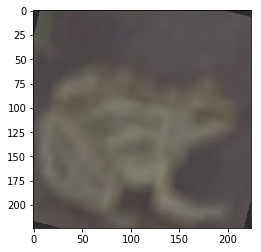

truck


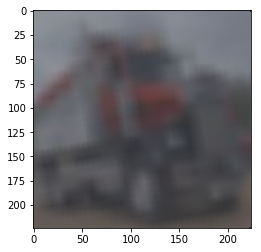

car


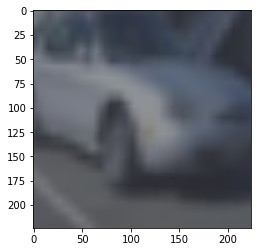

dog


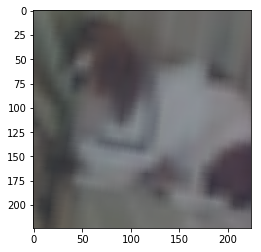

cat


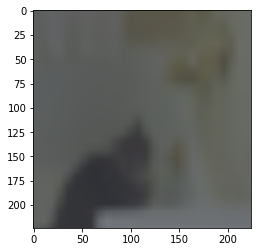

In [9]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [10]:
## YOUR CODE HERE ##

model=models.resnet50(pretrained=True)

# Freeze early layers
for param in model.parameters():
        param.requires_grad = False
        
# Add on classifier       
n_inputs=model.fc.in_features
model.fc = nn.Sequential(
                           nn.Linear(n_inputs, 256),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(256, 10),
                           nn.LogSoftmax(dim=1))
                           


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 93584289.58it/s]


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
## YOUR CODE HERE ##
# specify loss function
criterion = nn.NLLLoss()
# specify optimizer
optimizer = optim.Adam(model.fc.parameters())
# specify a scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
# Initialization of the variables 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss=0
val_loss=0
val_acc=0

train_loss_plt=[]
valid_loss_plt=[]
val_acc_plt=[]
epochs=20


# Early stopping details
n_epochs_stop = 5
min_val_loss = np.Inf
epochs_no_improve = 0

# GPU activation
model.to(device)

for epoch in range(epochs):
    
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        logps = model(images)
        loss = criterion(logps, labels)
        train_loss += loss.item()
        # backward pass     
        loss.backward()
        # Update the parameters
        optimizer.step()
        
    # deactivate gradients descent    
    with torch.no_grad():
        
        # switch the model to evaluation mode
        model.eval()
        
        for images, labels in valid_loader:       
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            # Validation loss
            loss = criterion(logps, labels)
            val_loss += loss.item()
            # Calculate validation accuracy
            ps = torch.exp(logps)
            top_ps , top_classes = ps.topk(1, dim=1)
            equal = top_classes == labels.view(*top_classes.shape)
            val_acc += torch.mean(equal.type(torch.FloatTensor)).item()
            
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(valid_loader)

        # Calculate average accuracy
        val_acc = val_acc / len(valid_loader)
    
           # If the validation loss is at a minimum    
        if val_loss < min_val_loss:
                # Save the model
                torch.save(model, 'checkpoint.pth')
                epochs_no_improve = 0
                min_val_loss = val_loss

        else:
                
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!')

            # Load in the best model
            model = torch.load('checkpoint.pth')
            
                
    train_loss_plt.append(train_loss)
    valid_loss_plt.append(val_loss)
    val_acc_plt.append(val_acc)
                
    print(f"epoch: {epoch+1}/{epochs}.. "
          f"train_loss: {train_loss: .3f}.. "
          f"validate_loss: {val_loss: .3f}.. "
          f"val_accuracy: {val_acc: .3f}")
    
    scheduler.step(val_loss)
    
    train_loss=0 
    model.train()
        
       


epoch: 1/20.. train_loss:  1.089.. validate_loss:  0.791.. val_accuracy:  0.725
epoch: 2/20.. train_loss:  0.917.. validate_loss:  0.714.. val_accuracy:  0.765
epoch: 3/20.. train_loss:  0.865.. validate_loss:  0.708.. val_accuracy:  0.772
epoch: 4/20.. train_loss:  0.850.. validate_loss:  0.673.. val_accuracy:  0.782
epoch: 5/20.. train_loss:  0.837.. validate_loss:  0.676.. val_accuracy:  0.780
epoch: 6/20.. train_loss:  0.841.. validate_loss:  0.677.. val_accuracy:  0.780
epoch: 7/20.. train_loss:  0.837.. validate_loss:  0.679.. val_accuracy:  0.780
epoch: 8/20.. train_loss:  0.840.. validate_loss:  0.685.. val_accuracy:  0.775
Early stopping!
epoch: 9/20.. train_loss:  0.842.. validate_loss:  0.680.. val_accuracy:  0.777
epoch: 10/20.. train_loss:  0.846.. validate_loss:  0.690.. val_accuracy:  0.776
epoch: 11/20.. train_loss:  0.844.. validate_loss:  0.674.. val_accuracy:  0.780
epoch: 12/20.. train_loss:  0.839.. validate_loss:  0.683.. val_accuracy:  0.777
epoch: 13/20.. train_

Plot the training loss (and validation loss/accuracy, if recorded).

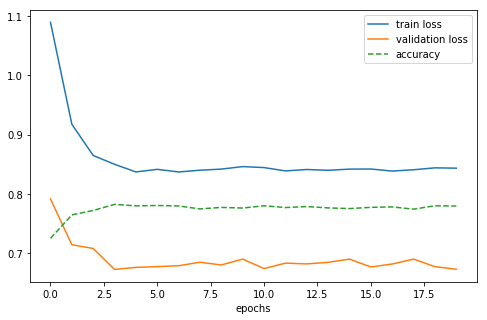

In [16]:
## YOUR CODE HERE ##
plt.figure(figsize=(8, 5))
plt.plot(train_loss_plt, label="train loss")
plt.plot(valid_loss_plt, label="validation loss")
plt.plot(val_acc_plt, label="accuracy", linestyle='dashed')
plt.xlabel('epochs')
plt.legend();

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
## YOUR CODE HERE ##

test_acc = 0

with torch.no_grad():
    
    # test loop
    
    for images, labels in test_loader:
        
        model.eval()
        
        images, labels = images.to(device), labels.to(device)
        
        logps = model(images)
        
        loss = criterion(logps, labels)
        ps = torch.exp(logps)
        
        top_p, top_classes = ps.topk(1, dim=1) 
        
        equal = top_classes == labels.view(*top_classes.shape)
        
        test_acc += torch.mean(equal.type(torch.FloatTensor))
                               
print(f"Test Accuracy : {100*test_acc/len(test_loader):.1f} %")                              

Test Accuracy : 77.2 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
# Saving the model
torch.save(model, 'checkpoint.pth')
print("Model SAVED!")


Model SAVED!


## Make a Recommendation

* The model I built is more accurate than the Detectocorp's model. Where the Detectocorp model scored 70% on accuracy and my model scored 77.2% (accuracy).

* Comparing my model to the more advanced solutions it is simpler to build but efficient because, instead of training a model from scratch, we used existing architectures that have been trained on a large dataset and then tune them for our task. This reduces the time to train and often results in better overall performance. 

* To achieve the 77.2% accuracy I used dropout, early stopping and scheduler for the inputs and ouputs.

* However, If I condsidered improving my model, I might use feature selection process to find the best subset of attributes and  increase the learning rate a little bit.
